In [36]:
import torch
import torch.nn as nn
from torch.functional import F
from sklearn import metrics
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
%matplotlib inline
import numpy as np
from utils import plot_confusion_matrix

In [37]:
x_train = torch.load("dataset/x_train")
y_train = torch.load("dataset/y_train")
x_test = torch.load("dataset/x_test")
y_test = torch.load("dataset/y_test")

In [38]:
class BiRNN(nn.Module):
    def __init__(self, embed_size, num_hiddens, num_layers, classes):
        super(BiRNN, self).__init__()
        # bidirectional设为True即得到双向循环神经网络

        self.encoder = nn.LSTM(input_size=embed_size,
                               hidden_size=num_hiddens,
                               num_layers=num_layers,
                               bidirectional=True)
        
        # 初始时间步和最终时间步的隐藏状态作为全连接层输入
        self.classifier = nn.Sequential(
            nn.Linear(4*num_hiddens, 128*num_hiddens),
            nn.BatchNorm1d(128*num_hiddens),
            nn.Sigmoid(),
            nn.Linear(128*num_hiddens,classes)
        )


    def forward(self, inputs):
        # inputs的形状是(批量大小, 词数, 词向量维度)，因为LSTM需要将序列长度(seq_len)作为第一维，所以将输入转置后
        # 再提取词特征，输出形状为(词数, 批量大小, 词向量维度)
        inputs = torch.transpose(inputs, 0, 1)
        # outputs形状是(词数, 批量大小, 2 * 隐藏单元个数)
        outputs, _ = self.encoder(inputs)  # output, (h, c)
        # 连结初始时间步和最终时间步的隐藏状态作为全连接层输入。它的形状为 (批量大小, 4 * 隐藏单元个数)。
        outs = torch.cat((outputs[0], outputs[-1]), -1)
        outs = self.classifier(outs)
        return outs

In [39]:
model = BiRNN(embed_size=100, num_hiddens=100, num_layers=5, classes=5)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [40]:
def batch_padding(batch_data):
    # 针对一批句子的长度（词向量个数）不一样时，全部补0到最大句子长度
    new_batch_data = []
    max_len = 0
    for s in batch_data:
        s = torch.tensor(s)
        new_batch_data.append(s)
        max_len = max(max_len,s.shape[0])
    for i in range(len(new_batch_data)):
        new_batch_data[i] = F.pad(new_batch_data[i], [0, 0, 0, max_len-new_batch_data[i].shape[0]])
    return torch.stack(new_batch_data, 0)	

In [41]:
sentences = batch_padding(x_train[0:5])
sentences.shape # [batch_size,句子中词的个数,词向量维度]

torch.Size([5, 7, 100])

In [42]:
print(model(sentences.to(device))) # 输出为OneHot编码形式

tensor([[-0.4730, -0.7638, -0.4803,  0.0971, -0.1239],
        [-0.4689, -0.7375, -0.4856,  0.0844, -0.1205],
        [-0.4603, -0.7418, -0.4891,  0.1052, -0.0843],
        [-0.4547, -0.7355, -0.4819,  0.1160, -0.1241],
        [-0.4782, -0.7423, -0.4770,  0.1204, -0.1115]], device='cuda:0',
       grad_fn=<AddmmBackward>)


## 训练

In [43]:
def train(model,dataset_x,dataset_y,num_epochs,
batch_size,optimizer,loss,batch_loss_list,batch_acc_list):
    model.train()
    for epoch in range(num_epochs):
        print("epoch",epoch)
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        batch_num = len(dataset_x) // batch_size
        for i in range(batch_num):
            X = batch_padding(dataset_x[i*batch_size : (i+1)*batch_size]).to(device)
            y = torch.tensor(dataset_y[i*batch_size : (i+1)*batch_size]).to(device)
            y_hat = model(X)
            y = y.argmax(dim=1).long()
            loss_ = loss(y_hat, y)
            optimizer.zero_grad()
            loss_.backward()
            optimizer.step()

            batch_loss = loss_.cpu().item()
            batch_acc = (y_hat.argmax(dim=1) == y).sum().cpu().item()
            batch_loss_list.append(batch_loss/batch_size)
            batch_acc_list.append(batch_acc/batch_size)
            print(f"epoch:{epoch},batch loss:{batch_loss/batch_size},batch acc:{batch_acc/batch_size}")
        

In [44]:
lr = 0.001
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad,model.parameters()), lr=lr)
loss = nn.CrossEntropyLoss().to(device) 

In [45]:
batch_loss_list = []
batch_acc_list = []

In [46]:
print("training... ")
train(model=model,dataset_x=x_train,dataset_y=y_train,
num_epochs=10,batch_size=256,optimizer=optimizer,loss=loss,
batch_loss_list=batch_loss_list,batch_acc_list=batch_acc_list)
torch.save(model,"models/BiLSTM_v3.npy")

training... 
epoch 0
epoch:0,batch loss:0.0062833563424646854,batch acc:0.13671875
epoch:0,batch loss:0.025222299620509148,batch acc:0.45703125
epoch:0,batch loss:0.01763886585831642,batch acc:0.390625
epoch:0,batch loss:0.006865662056952715,batch acc:0.26953125
epoch:0,batch loss:0.01054459623992443,batch acc:0.234375
epoch:0,batch loss:0.014537299983203411,batch acc:0.296875
epoch:0,batch loss:0.008501166477799416,batch acc:0.359375
epoch:0,batch loss:0.007594303693622351,batch acc:0.40234375
epoch:0,batch loss:0.006314525380730629,batch acc:0.41796875
epoch:0,batch loss:0.010035855695605278,batch acc:0.23828125
epoch:0,batch loss:0.0063283564522862434,batch acc:0.4609375
epoch:0,batch loss:0.006547016557306051,batch acc:0.484375
epoch:0,batch loss:0.006508819293230772,batch acc:0.40625
epoch:0,batch loss:0.006617633625864983,batch acc:0.3515625
epoch:0,batch loss:0.006267000455409288,batch acc:0.26171875
epoch:0,batch loss:0.006851565558463335,batch acc:0.25
epoch:0,batch loss:0.006

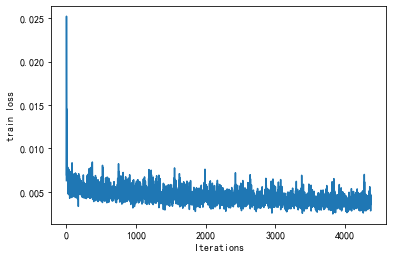

In [47]:
plt.xlabel('Iterations')
plt.ylabel('train loss')
plt.plot(np.arange(len(batch_loss_list)), batch_loss_list)

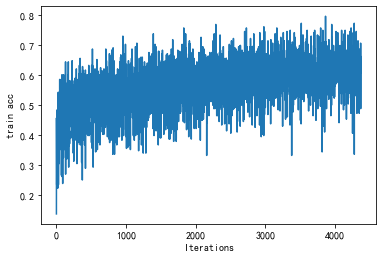

In [48]:
plt.xlabel('Iterations')
plt.ylabel('train acc')
plt.plot(np.arange(len(batch_acc_list)), batch_acc_list)

## 测试

In [49]:
def test(model,dataset_x,dataset_y,pred_list,real_list):
    model.eval()
    for i in range(len(dataset_x)):
        X = torch.tensor([dataset_x[i]]).to(device)
        y = torch.tensor([dataset_y[i]]).to(device)
        y_hat = model(X)
        pred_list.append(y_hat.argmax(dim=1).cpu().item())
        real_list.append(y.argmax(dim=1).cpu().item())

In [50]:
model = torch.load("models/BiLSTM_v3.npy")
pred_list = []
real_list = []
print("testing... ")
test(model,x_test,y_test,pred_list,real_list)

testing... 


In [51]:
print(metrics.classification_report(real_list,pred_list))

              precision    recall  f1-score   support

           0       0.72      0.45      0.56      2396
           1       0.24      0.39      0.30       731
           2       0.22      0.45      0.29       786
           3       0.31      0.77      0.44       883
           4       0.84      0.72      0.77     11256

    accuracy                           0.65     16052
   macro avg       0.47      0.55      0.47     16052
weighted avg       0.74      0.65      0.68     16052



显示百分比：
[[ 0.45  0.05  0.05  0.09  0.36]
 [ 0.04  0.39  0.06  0.14  0.37]
 [ 0.03  0.09  0.45  0.12  0.32]
 [ 0.00  0.04  0.02  0.77  0.17]
 [ 0.03  0.06  0.10  0.09  0.72]]


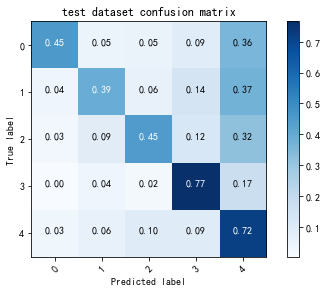

In [52]:
cm = metrics.confusion_matrix(real_list,pred_list)
plot_confusion_matrix(cm,range(5),normalize=True,title='test dataset confusion matrix')